In [1]:
import numpy as np
from pandas import *
import matplotlib.pyplot as plt
import statsmodels.api as sm
import QuantLib as ql
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
%matplotlib inline
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF
import seaborn as sns
import matplotlib.mlab as mlab
import edward as ed
from edward.util import rbf
import scipy 

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [260]:
def makeSwap(start, maturity, nominal, fixedRate, index, typ=ql.VanillaSwap.Payer):
        end = ql.TARGET().advance(start, maturity)
        fixedLegTenor = ql.Period("6M")
        fixedLegBDC = ql.ModifiedFollowing
        fixedLegDC = ql.Thirty360(ql.Thirty360.BondBasis)
        spread = 0.0
        fixedSchedule = ql.Schedule(start, end,  fixedLegTenor,   index.fixingCalendar(),   fixedLegBDC,  fixedLegBDC,   ql.DateGeneration.Backward,   False)
        floatSchedule = ql.Schedule(start, end,  index.tenor(),  index.fixingCalendar(),   index.businessDayConvention(),  index.businessDayConvention(),   ql.DateGeneration.Backward,  False)
        swap = ql.VanillaSwap(typ,  nominal,  fixedSchedule,  fixedRate,  fixedLegDC,  floatSchedule,  index,  spread,  index.dayCounter())
        return swap, [index.fixingDate(x) for x in floatSchedule][:-1]

def makeSwaption(swap, callDates, settlement):
    if len(callDates) == 1:
        exercise = ql.EuropeanExercise(callDates[0])
    else:
        exercise = ql.BermudanExercise(callDates)
    return ql.Swaption(swap, exercise, settlement)

def timeFromReferenceFactory(daycounter, ref):
    def impl(dat):
        return daycounter.yearFraction(ref, dat)
    return np.vectorize(impl)

def getFixedLeg(swap, t):
    fixed_leg = swap.leg(0)
    n = len(fixed_leg)
    fixed_times=[]
    fixed_amounts=[]
    npv = 0
    for i in range(n):
        cf = fixed_leg[i]
        t_i = timeFromReference(cf.date())
        if t_i > t:
            fixed_times.append(t_i)
            fixed_amounts.append(cf.amount())
    return np.array(fixed_times), np.array(fixed_amounts)

def getFloatingLeg(swap, t):
    float_leg = swap.leg(1)
    n = len(float_leg)
    float_times = []
    float_dcf = []
    accrual_start_time = []
    accrual_end_time = []
    nominals = []
    for i in range(n):
        # convert base classiborstart_idx Cashflow to
        # FloatingRateCoupon
        cf = ql.as_floating_rate_coupon(float_leg[i])
        value_date = cf.referencePeriodStart()
        t_fix_i = timeFromReference(value_date)
        t_i = timeFromReference(cf.date()) 
        if t_fix_i >= t:
            iborIndex = cf.index()
            index_mat = cf.referencePeriodEnd()
            # year fraction
            float_dcf.append(cf.accrualPeriod())
            # calculate the start and end time
            accrual_start_time.append(t_fix_i)
            accrual_end_time.append(timeFromReference(index_mat))
            # payment time
            float_times.append(t_i)
            # nominals 
            nominals.append(cf.nominal())
    return np.array(float_times), np.array(float_dcf), np.array(accrual_start_time), np.array(accrual_end_time), np.array(nominals)
    
def getFixedFloatingPeriod(swap, t):
    float_leg = swap.leg(1)
    n = len(float_leg)
    for i in range(n):
        cf = ql.as_floating_rate_coupon(float_leg[i])
        value_date = cf.referencePeriodStart()
        t_fix_i = timeFromReference(value_date)
        t_i = timeFromReference(cf.date()) 
        if t_fix_i < t and t < t_i:
            iborIndex = cf.index()         
            index_mat = cf.referencePeriodEnd()
            # year fraction
            float_dcf = cf.accrualPeriod()
            # calculate the start and end time
            accrual_start_time = t_fix_i
            accrual_end_time = timeFromReference(index_mat)
            # payment time
            float_times = t_i
            # nominals 
            nominals = cf.nominal()
            return (float(float_times), float(float_dcf), float(accrual_start_time), float(accrual_end_time), float(nominals))
    return (float(t), 1., float(t), float(t), 0.)

def swapPathNPV(swap, t, timegrid):
    fixed_times, fixed_amounts = getFixedLeg(swap, t)
    float_times, float_dcf, accrual_start_time, accrual_end_time, nominals = getFloatingLeg(swap, t)
    df_times = np.concatenate([fixed_times,  accrual_start_time, accrual_end_time, float_times])
    df_times = np.unique(df_times)
    # Store indices of fix leg payment times in 
    # the df_times array
    fix_idx = np.in1d(df_times, fixed_times, True)
    fix_idx = fix_idx.nonzero()
    # Indices of the floating leg payment times 
    # in the df_times array
    float_idx = np.in1d(df_times, float_times, True)
    float_idx = float_idx.nonzero()
    # Indices of the accrual start and end time
    # in the df_times array
    accrual_start_idx = np.in1d(df_times, accrual_start_time, True)
    accrual_start_idx = accrual_start_idx.nonzero()
    accrual_end_idx = np.in1d(df_times, accrual_end_time, True)
    accrual_end_idx = accrual_end_idx.nonzero()
    paytime_ffp, float_dcf_ffp, accrual_start_time_ffp, accrual_end_time_ffp, nominals_ffp = getFixedFloatingPeriod(swap, t)
    # Calculate NPV
    def calc(path):
        if len(df_times)==0:
            return 0
        i = np.where(timegrid == t)[0][0]
        x_t = path[i]
        discount = np.vectorize(lambda T: model.zerobond(T, t, x_t))
        dfs = discount(df_times)
        # Calculate fixed leg npv
        fix_leg_npv = np.sum(fixed_amounts * dfs[fix_idx])
        # Estimate the index fixings
        index_fixings = (dfs[accrual_start_idx] / dfs[accrual_end_idx] - 1) 
        index_fixings /= float_dcf
        # Calculate the floating leg npv
        float_leg_npv = np.sum(nominals * index_fixings * float_dcf * dfs[float_idx])
        # Calculate the already fixed accrual period of the floating leg
        t_f = accrual_start_time_ffp
        i = np.where(timegrid == t_f)[0][0]
        x_f = path[i]
        df_e = model.zerobond(accrual_end_time_ffp, t_f, x_f)
        npv_accrualperiod = (1. / df_e - 1) * nominals_ffp * model.zerobond(paytime_ffp, t, x_t)
        # Calculate swap npv
        npv = float_leg_npv + npv_accrualperiod - fix_leg_npv
        return npv
    return calc
    
def fixingdates(swap):
    leg = swap.leg(1)
    n = len(leg)
    fixing_dates = []
    for i in range(0, n):
        cf = ql.as_floating_rate_coupon(leg[i])
        value_date = cf.referencePeriodStart()
        fixing_dates.append(value_date)
    return fixing_dates 

today = ql.Date(7,4,2015)
ql.Settings.instance().setEvaluationDate(today)
settlementDate = today + ql.Period("2D") 

In [2]:
test = np.linspace(0.01, 0.1, 15)
percentile = np.arange(5, 100, 5)

In [7]:
#test_CVA_1 = []
#test_delta_CVA = []
#test_pctl_delta_CVA = []
#test_VaR = []
#delta_CVA = []
#dist_CVA_1 = []
#CVA_VaR = []

In [8]:
for itr in test:
    fixedRate = itr + 0.002      # fixed rate must be larger than float so value of swap is 0 at inception.
    rate = ql.SimpleQuote(itr)   # Libor + 1% floating rate
    rate_handle = ql.QuoteHandle(rate)
    dc = ql.Actual365Fixed()
    yts = ql.FlatForward(today, rate_handle, dc)
    yts.enableExtrapolation()
    hyts = ql.RelinkableYieldTermStructureHandle(yts)
    t0_curve = ql.YieldTermStructureHandle(yts)
    libor1yr = ql.USDLibor(ql.Period(6, ql.Months), hyts)  
    cal = ql.TARGET()
    
    swaps = [makeSwap(settlementDate,  ql.Period("5Y"), 1e6,  fixedRate,  libor1yr) ]
    calldates = [ql.Date(7,4,2016), ql.Date(6,4,2017), ql.Date(5,4, 2018), ql.Date(5,4,2019)]
    calldates = [libor1yr.valueDate(d) for d in calldates]

    engine = ql.DiscountingSwapEngine(hyts)
    for swap, fixingDates in swaps:
        swap.setPricingEngine(engine)
    
    # Assume the model is already calibrated either historical or market implied
    volas = [ql.QuoteHandle(ql.SimpleQuote(0.0075)), ql.QuoteHandle(ql.SimpleQuote(0.0075))]
    meanRev = [ql.QuoteHandle(ql.SimpleQuote(0.002))]
    model = ql.Gsr(t0_curve, [today+100], volas, meanRev, 16.)
    process = model.stateProcess()
    
    mcDC = yts.dayCounter()
    timeFromReference = timeFromReferenceFactory(mcDC, today)
    
    callTimes = timeFromReference(calldates)
    swap = swaps[0][0]
    npv = swapPathNPV(swap, 0., np.array([0.]))(np.array([0.]))
    
    fixing_dates = fixingdates(swap)
    fixing_times = timeFromReference(fixing_dates )

    date_grid = [today + ql.Period(i, ql.Months) for i in range(0,66)] + calldates + fixing_dates

    date_grid = np.unique(np.sort(date_grid))
    time_grid = np.vectorize(lambda x: ql.Actual365Fixed().yearFraction(today, x))(date_grid)
    time_grid = np.unique(time_grid)
    dt = time_grid[1:] - time_grid[:-1]
    
    seed = 1
    urng = ql.MersenneTwisterUniformRng(seed)
    usrg = ql.MersenneTwisterUniformRsg(len(time_grid)-1,urng)
    generator = ql.InvCumulativeMersenneTwisterGaussianRsg(usrg)

    M = 10000
    m = len(time_grid)
    x = np.zeros((M, m))
    y = np.zeros((M, m))
    numeraires = np.zeros((M, m))
                      
    for n in range(0, M):
        numeraires[n, 0] = model.numeraire(0, 0)
    
    for n in range(0,M):
        dWs = generator.nextSequence().value()
        j = 1
        for i in range(1, len(time_grid)):
            t0 = time_grid[i-1]
            t1 = time_grid[i]
            e = process.expectation(t0, x[n,i-1],   dt[i-1])
            std = process.stdDeviation(t0,   x[n,i-1],  dt[i-1])
            x[n,i] = e + dWs[i-1] * std 
            e_0_0 = process.expectation(0,0,t1)
            std_0_0 = process.stdDeviation(0,0,t1)
            y[n,i] = (x[n,i] - e_0_0) / std_0_0
            numeraires[n, i] = model.numeraire(t1, y[n,i])
        
    swap_npvs = np.zeros((M, m))
    cont_value = np.zeros(numeraires[:,i].shape)
    for i in range(m-1, 0, -1):
        t = time_grid[i]
        pricer = swapPathNPV(swap, t, time_grid)
        swap_npvs[:, i] = np.apply_along_axis(pricer, 1, y) / numeraires[:, 0]
        exercise_values = np.zeros(numeraires[:,i].shape)
        if t in callTimes:
            exercise_values = swap_npvs[:, i].copy()
            exercise_values[exercise_values < 0] = 0
        states = y[:, i]
        Y = np.column_stack((states, states**2, states**3, states**4))
        Y = sm.add_constant(Y)
        ols = sm.OLS(cont_value, Y)
        ols_result = ols.fit()
        cont_value_hat = np.sum(ols_result.params * Y, axis=1)
        if t in callTimes:
            cont_value = np.maximum(cont_value_hat, exercise_values)
    swap_npvs[:, 0] = np.apply_along_axis(swapPathNPV(swap, 0, time_grid), 1, y) / numeraires[:, 0]
    swap_npvs *= numeraires[0,0]
    swap_npvs[swap_npvs<0] = 0
    EE_swap = np.mean(swap_npvs, axis=0)
    
    # calculation of current CVA
    pd_dates =  [today + ql.Period(i, ql.Years) for i in range(11)]
    hzrates = np.repeat(0.4, 11)
    pd_curve = ql.HazardRateCurve(pd_dates, hzrates, ql.Actual365Fixed())
    pd_curve.enableExtrapolation()
    
    defaultProb_vec = np.vectorize(pd_curve.defaultProbability)
    dPD = defaultProb_vec(time_grid[:-1], time_grid[1:])
    recovery = 0.4
    CVA_0 = (1-recovery) * np.sum(EE_swap[1:] * dPD)
    
    # calculation of 1 yr CVA
    noise_number = 100
    CVA_1 = np.zeros(noise_number)
    pd_dates_1 = [today + ql.Period(1, ql.Years) + ql.Period(i, ql.Years) for i in range(9)]
    hzrates_1 = np.random.normal(0.4, 0.1, noise_number)
    hzrates_1[hzrates_1 < 0] = 0
    
    for i in range(noise_number):
        pd_curve_1 = ql.HazardRateCurve(pd_dates_1, np.repeat(hzrates_1[i], len(pd_dates_1)) , ql.Actual365Fixed())
        pd_curve_1.enableExtrapolation()
        defaultProb_vec_1 = np.vectorize(pd_curve_1.defaultProbability)
        dPD_1 = defaultProb_vec_1(time_grid[:-3], time_grid[3:])   # from the 4th time grid, which is the first cash flow after yr 1
        CVA_1[i] = (1-recovery) * np.sum(EE_swap[3:] * dPD_1)
    
    #dist_CVA_1.append(CVA_1)
    test_CVA_1.append(CVA_1)
    
    #calculation of delta_CVA
    test_delta_CVA.append(CVA_1 - CVA_0)
    #delta_CVA.append(np.mean(CVA_1) - CVA_0)
    
    #calculation of percentiles of delta CVA
    for i in percentile:
        temp = np.percentile(np.array(CVA_1 - CVA_0), i)
        test_pctl_delta_CVA.append(temp)
    
    # calculation of CVA VaR 
    VaR = np.percentile(np.array(CVA_1 - CVA_0), 90)     # 90% quantile as VaR 
    #CVA_VaR.append(VaR)
    test_VaR.append(VaR)
    
    print VaR, np.mean(CVA_1) - CVA_0

7455.76622652 6533.43045291
7305.27247531 6386.84604785
7336.43342969 6425.29891875
7626.53114921 6580.85986516
7574.93604994 6715.01537316
7604.42003874 6683.72694278
7916.6384134 6941.57888384
8016.78523503 7002.23005097
8272.74588538 7175.09988058
8673.5871991 7604.8275602
8845.34091736 7570.96214159
9265.52387709 7993.52880291
9509.2210778 8080.51926653
9990.35142999 8732.75132685
10462.0178666 9166.21823969


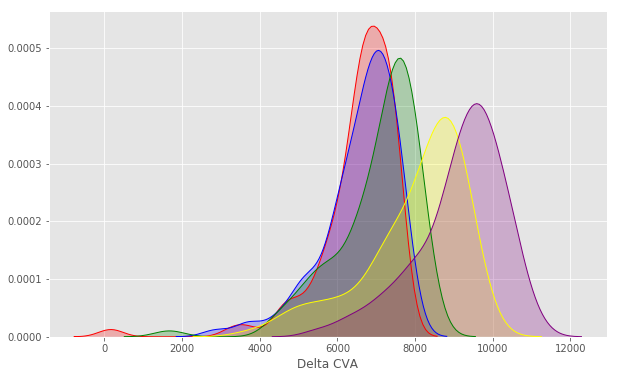

In [258]:
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.xlabel('Delta CVA')
sns.distplot(test_delta_CVA[0], hist=False, color = 'red', kde = True, kde_kws = {'shade': True, 'linewidth': 1})
sns.distplot(test_delta_CVA[3], hist=False, color = 'blue', kde = True, kde_kws = {'shade': True, 'linewidth': 1})
sns.distplot(test_delta_CVA[7], hist=False, color = 'green', kde = True, kde_kws = {'shade': True, 'linewidth': 1})
sns.distplot(test_delta_CVA[11], hist=False, color = 'yellow', kde = True, kde_kws = {'shade': True, 'linewidth': 1})
sns.distplot(test_delta_CVA[14], hist=False, color = 'purple', kde = True, kde_kws = {'shade': True, 'linewidth': 1})

Text(0,0.5,'Delta CVA')

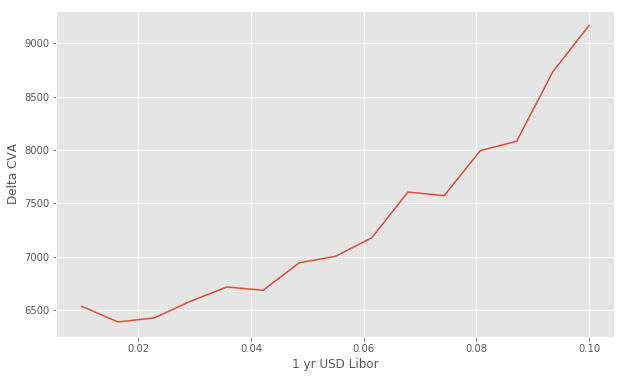

In [10]:
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(test, np.mean(test_delta_CVA, axis=1))
plt.xlabel('1 yr USD Libor')
plt.ylabel('Delta CVA')    

In [2567]:
#mse = []
#error_VaR = []

In [261]:
x = np.hstack(np.repeat(test[i], noise_number) for i in range(len(test)))
y = np.hstack(test_delta_CVA[i] for i in range(len(test)))

In [4]:
url = 'https://raw.githubusercontent.com/xiwenjin/Bayesian-modeling/master/data/experiment%201.csv'
df = pd.read_csv(url, header=None)
x = np.array(df.iloc[:,0])
y = np.array(df.iloc[:,1])

In [316]:
training_number = 1500
#testing_number = 100

train_idx = np.linspace(0, len(x)-1, training_number, dtype = 'int')
x_train = np.array(x[train_idx], dtype='float32').reshape(training_number, 1) 
y_train = np.array(y, dtype='float32')[train_idx]   #.reshape(training_number, 1)

test_idx = np.arange(1, len(x)-1, noise_number)
x_test = np.array(x[test_idx], dtype='float32').reshape(len(test_idx), 1)
y_test = np.mean(np.array(test_delta_CVA), axis=1)

In [532]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-10, 1e+10)) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-10, 1e+10))
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer= 20, normalize_y=True)
gp.fit(x_train, y_train)
y_pred, sigma = gp.predict(x_test, return_std=True)
y_samples = gp.sample_y(x_test, 1000)
up = y_pred - 2 * sigma 
down = y_pred + 2 * sigma
gp.kernel_

RBF(length_scale=0.0235) + WhiteKernel(noise_level=1.87e+06)

In [531]:
sess = ed.get_session()
l = np.array(gp.kernel_.k1.length_scale, dtype = 'float32')                
noise_term =  np.array(gp.kernel_.k2.noise_level, dtype = 'float32')     

Kernel = rbf(x_train, lengthscale=l).eval()
K_noise = Kernel + np.eye(training_number) * noise_term  # without noise, the cov band converge to 0 at the training points 
k_s = rbf(x_test, x_train).eval()                   
L = np.linalg.cholesky(K_noise)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
predict_mean = np.dot(k_s, alpha)

# cov
v = np.linalg.solve(L, k_s.T)
var = rbf(x_test).eval() - np.dot(v.T, v)
std = np.sqrt(np.diag(var))

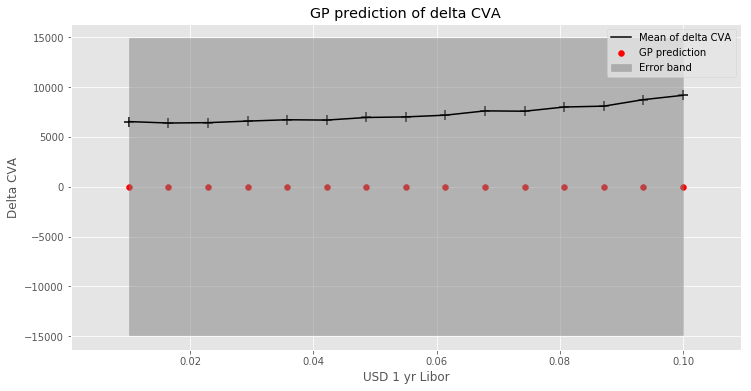

In [530]:
plt.figure(figsize = (12, 6), facecolor='white', edgecolor='black')
plt.scatter(x_test, y_pred, color = 'red', label = 'GP prediction', s=35)
#plt.scatter(x_test, y_test, color = 'black', label = 'Analytical model')
#plt.scatter(x_train, y_train, color = 'black', marker = '+', s = 65) 
plt.plot(x_test, y_test, color = 'black', label ='Mean of delta CVA')
plt.scatter(x_test, y_test, color = 'black', marker = '+', s = 95) 
plt.fill_between(x_test.flatten(), up, down, color = 'grey', alpha=0.5, label = 'Error band') 
plt.title('GP prediction of delta CVA')
plt.xlabel('USD 1 yr Libor')
plt.ylabel('Delta CVA')
plt.legend(loc = 'best', prop={'size':10})
plt.grid(True)

In [5]:
plt.figure(figsize = (12, 6), facecolor='white', edgecolor='black')
sns.distplot(y_samples[14], hist=False, kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Density of posterior')
sns.distplot(test_delta_CVA[14], hist=False, color = 'green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Density of Delta CVA')

NameError: name 'y_samples' is not defined

<Figure size 864x432 with 0 Axes>

Text(0,0.5,'Density')

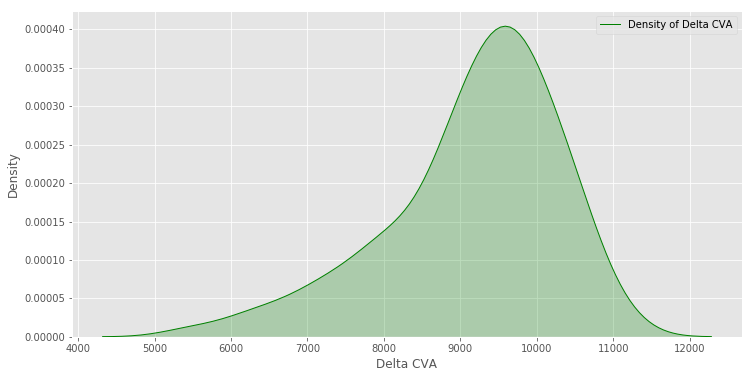

In [17]:
plt.figure(figsize = (12, 6), facecolor='white', edgecolor='black')
mu = np.mean(test_delta_CVA[14])
std = np.std(test_delta_CVA[14])
axis = np.linspace(mu - 3*std, mu + 3*std, 100)
#plt.plot(axis, mlab.normpdf(axis, mu, std), color = 'black')
sns.distplot(test_delta_CVA[14], hist=False, color = 'green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Density of Delta CVA')
plt.legend(loc = 'best', prop={'size':10})
plt.xlabel('Delta CVA')
plt.ylabel('Density')

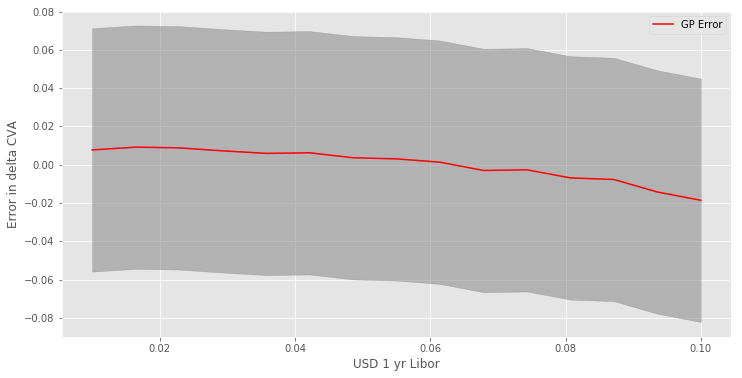

In [19]:
plt.figure(figsize = (12,6),facecolor='white', edgecolor='black')
plt.plot( x_test, y_pred - y_test, color = 'red', label = 'GP Error')
plt.fill_between(x_test.flatten(), up-y_test, down - y_test, color = 'grey', alpha=0.5) 
plt.grid(True)
plt.xlabel('USD 1 yr Libor')
plt.ylabel('Error in delta CVA')
plt.legend(loc = 'best', prop={'size':10})

# simple number test

In [62]:
np.mean(np.random.normal(9,1,200))

9.0070041717356393

In [67]:
np.random.rand(1)*10

array([ 0.75815579])

In [248]:
a = np.linspace(10, 35, 10)
b = np.random.rand(10)*1000
x = np.hstack(np.repeat(a[i], 200) for i in range(len(a)))
temp = []
for i in range(len(b)):
    temp.append(np.random.normal(b[i], 2, 200))
y = np.hstack(temp[i] for i in range(len(a)))

In [249]:
training_number = 2000

train_idx = np.linspace(0, len(x)-1, training_number, dtype = 'int')
x_train = np.array(x[train_idx], dtype='float32').reshape(training_number, 1) 
y_train = np.array(y, dtype='float32')[train_idx]   #.reshape(training_number, 1)

x_test = a.reshape(len(a), 1)
y_test = np.zeros(len(a))
for i in range(len(a)):
    y_test[i] = np.mean(temp[i])
    
#y_test = b

In [250]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-10, 1e+10)) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-10, 1e+0))
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer= 50, normalize_y=True)
gp.fit(x_train, y_train)
y_pred, sigma = gp.predict(x_test, return_std=True)
y_samples = gp.sample_y(x_test, 1000)
up = y_pred - 2 * sigma 
down = y_pred + 2 * sigma
gp.kernel_

RBF(length_scale=2.12) + WhiteKernel(noise_level=1)

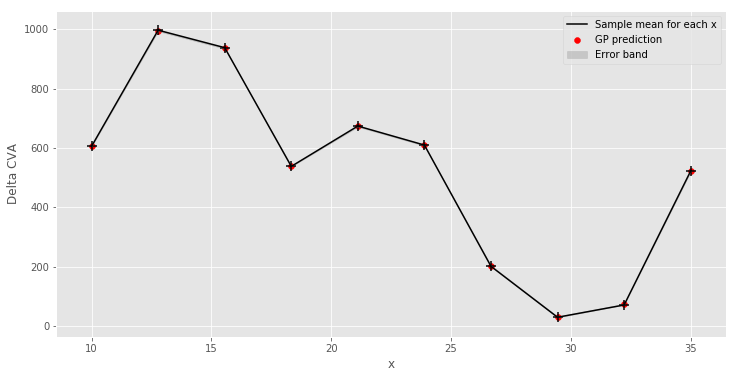

In [251]:
plt.figure(figsize = (12, 6), facecolor='white', edgecolor='black')
plt.scatter(x_test, y_pred, color = 'red', label = 'GP prediction', s=35)
#plt.scatter(x_test, y_test, color = 'black', label = 'Analytical model')
#plt.scatter(x_train, y_train, color = 'black', marker = '+', s = 65) 
plt.plot(x_test, y_test, color = 'black', label ='Sample mean for each x')
plt.scatter(x_test, y_test, color = 'black', marker = '+', s = 95) 
plt.fill_between(x_test.flatten(), up, down, color = 'grey', alpha=0.3, label = 'Error band') 
#plt.title('GP prediction of delta CVA')
plt.xlabel('x')
plt.ylabel('Delta CVA')
plt.legend(loc = 'best', prop={'size':10})
plt.grid(True)

In [252]:
y_pred, sigma

(array([ 606.26919994,  995.56035997,  936.73594609,  539.42716997,
         673.35962152,  609.44327424,  202.85614839,   30.79291718,
          73.40189244,  521.89000918]),
 array([ 1.00248123,  1.00247716,  1.0024764 ,  1.00247627,  1.00247625,
         1.00247625,  1.00247627,  1.0024764 ,  1.00247716,  1.00248123]))

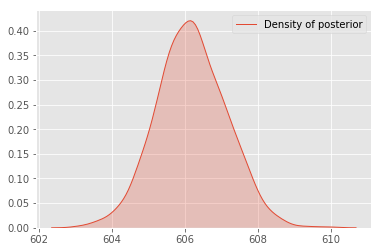

In [254]:
sns.distplot(y_samples[0], hist=False, kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Density of posterior')